# Correct virtual library

We have found a problem with the products originating from TerTH010:
The E-configuration of the double bound in this terminator was not transferred to products.
We will fix this here.

In [315]:
import pathlib
import sys

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from rdkit.Chem.rdchem import BondStereo

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection
from src.library_design.reaction_generator import SFReactionGenerator
from src.util.rdkit_util import desalt_building_block, remove_monomer_pg_chirality

In [4]:
con.con.execute("PRAGMA table_info(virtuallibrary)").fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'initiator_long', 'TEXT', 1, None, 0),
 (2, 'monomer_long', 'TEXT', 1, None, 0),
 (3, 'terminator_long', 'TEXT', 1, None, 0),
 (4, 'type', 'TEXT', 1, None, 0),
 (5, 'SMILES', 'TEXT', 0, None, 0),
 (6, 'boc', 'INTEGER', 0, None, 0),
 (7, 'cbz', 'INTEGER', 0, None, 0),
 (8, 'tbu', 'INTEGER', 0, None, 0),
 (9, 'tms', 'INTEGER', 0, None, 0),
 (10, 'comment', 'TEXT', 0, None, 0),
 (11, 'molecular_formula_1', 'REAL', 0, None, 0),
 (12, 'lcms_mass_1', 'REAL', 0, None, 0),
 (13, 'molecular_formula_alt', 'TEXT', 0, None, 0),
 (14, 'lcms_mass_alt', 'TEXT', 0, None, 0)]

In [23]:
con = SynFermDatabaseConnection()
res = con.con.execute("SELECT id, initiator_long, monomer_long, terminator_long, type, SMILES FROM virtuallibrary WHERE terminator_long = 'TerTH010'").fetchall()
header = ["id", "initiator_long", "monomer_long", "terminator_long", "type", "SMILES"]
df = pd.DataFrame(res, columns=header)
df.head()

,id,initiator_long,monomer_long,terminator_long,type,SMILES
0,25,2-Pyr002,Fused002,TerTH010,A,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C...
1,66,2-Pyr002,Fused005,TerTH010,A,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(C=C...
2,107,2-Pyr002,Fused006,TerTH010,A,O=C(N[C@H]1CCC[C@H]1c1nnc(C=Cc2ccccc2)s1)c1cc(...
3,148,2-Pyr002,Fused011,TerTH010,A,O=C(N[C@H]1COc2ccccc2[C@@H]1c1nnc(C=Cc2ccccc2)...
4,189,2-Pyr002,Mon096,TerTH010,A,CC(C)(C)OC(=O)N1CC([C@H](Cc2nnc(C=Cc3ccccc3)s2...


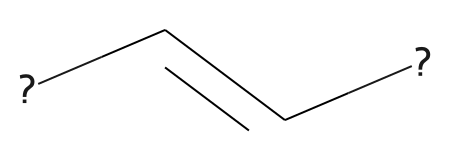

In [299]:
# pattern to identify the double bond in products originating from TerTH010
# matches four atoms: the carbon that used to be the thiohydrazide carbonyl,
# the two double bond atoms and the first atom of the phenyl ring on the other side
# note that on the thiohydrazide side the pattern is less specific to account for the non-aromatized products
# in particular the carbonyl-C to N bond is undefined to match either aromatic or double bonds
pat = Chem.MolFromSmarts("[$([#6]([#16])~[#7][#7])]-C=C-[$([cX3]1[cX3H][cX3H][cX3H][cX3H][cX3H]1)]") 
pat

In [304]:
with_stereo = []
for i, (smi, t) in df.loc[~df.type.isin(["F", "G"]), ["SMILES", "type"]].iterrows():
    if smi:  # for some product H, no SMILES exist, b/c it would be chemically invalid
        mol = Chem.MolFromSmiles(smi)

        atom_idx = mol.GetSubstructMatches(pat)

        if t == "E":
            assert len(atom_idx) == 2  # the dimer should have two matches of course
        else:
            assert len(atom_idx) == 1

        for a_idx in atom_idx:

            bond = mol.GetBondBetweenAtoms(a_idx[1], a_idx[2])

            if a_idx[1] < a_idx[2]:
                prec = a_idx[0]
                subs = a_idx[3]
            else:
                prec = a_idx[3]
                subs = a_idx[0]

            # set preceeding and follow atom that define stereo chem. First argument is the atom connected to the bond atom with lower idx
            bond.SetStereoAtoms(prec, subs)

            # set stereo descriptor
            bond.SetStereo(BondStereo.STEREOE)

            # set direction of preceeding and following bond
            mol.GetBondBetweenAtoms(a_idx[0], a_idx[1]).SetBondDir(Chem.rdchem.BondDir.ENDUPRIGHT)
            mol.GetBondBetweenAtoms(a_idx[2], a_idx[3]).SetBondDir(Chem.rdchem.BondDir.ENDUPRIGHT)

        Chem.SanitizeMol(mol)
        with_stereo.append(Chem.MolToSmiles(mol))
    else:
        with_stereo.append(None)

In [347]:
# add the new product SMILES back to dataframe
df.loc[~df.type.isin(["F", "G"]), "SMILES"] = with_stereo

## Doublecheck the products with SFReactionGenerator$
(we can only check type A)

In [303]:
rxn_generator = SFReactionGenerator()

RDKit WARNING: [11:33:37] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
RDKit WARNING: [11:33:37] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
[11:33:37] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels
[11:33:37] Mismatched potential rlabels: 2 unmapped reactant dummy atom rlabels,0 unmappped product dummy atom rlabels


In [317]:
building_blocks = {
    long: Chem.MolToSmiles(
        remove_monomer_pg_chirality(desalt_building_block(smiles))
    )
    if (
        long.startswith("Mon")
        or long.startswith("Fused")
        or long.startswith("Spiro")
    )
    else Chem.MolToSmiles(desalt_building_block(smiles))
    for long, smiles in con.building_blocks()
}

In [348]:
reactants = [tuple(bbs) for i, bbs in df.loc[df.type == "A", ["initiator_long", "monomer_long", "terminator_long", "type"]].iterrows()]

In [358]:
prods = []
failed_reactants = []
for bbs in reactants:
    if bbs[3] == "A":
        try:
            prods.append(Chem.MolToSmiles(rxn_generator.generate_product([Chem.MolFromSmiles(building_blocks[smi]) for smi in bbs[:3]])))
        except RuntimeError as e:
            failed_reactants.append(bbs)
            prods.append(None)


In [362]:
# compare SFReactionGeneratorProducts
for i, j in zip(prods, df.loc[df.type == "A", "SMILES"]):
    if i != j:
        print(i)
        print(j)

None
COc1ccc(CCOC(=O)N2C[C@H](NC(=O)n3nccc3C(=O)OC(C)(C)C)[C@H](c3nnc(/C=C/c4ccccc4)s3)C2)cc1OC
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(/C=C/c2ccccc2)s1
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@H]1CCC[C@H]1c1nnc(/C=C/c2ccccc2)s1
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@H]1COc2ccccc2[C@@H]1c1nnc(/C=C/c2ccccc2)s1
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@@H](Cc1nnc(/C=C/c2ccccc2)s1)C1CN(C(=O)OC(C)(C)C)C1
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@H]1COc2cc(-c3cccc(C#N)c3)ccc2[C@@H]1c1nnc(/C=C/c2ccccc2)s1
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@H]1Cn2cnc(Br)c2[C@H]1c1nnc(/C=C/c2ccccc2)s1
None
CC(=O)N1C[C@H](NC(=O)n2nccc2C(=O)OC(C)(C)C)[C@H](c2nnc(/C=C/c3ccccc3)s2)C1
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@H](Cc1nnc(/C=C/c2ccccc2)s1)CC(F)(F)F
None
CC(C)[C@@H](Cc1nnc(/C=C/c2ccccc2)s1)NC(=O)n1nccc1C(=O)OC(C)(C)C
None
CC(C)C[C@@H](Cc1nnc(/C=C/c2ccccc2)s1)NC(=O)n1nccc1C(=O)OC(C)(C)C
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@H](Cc1nnc(/C=C/c2ccccc2)s1)c1cccnc1
None
CC(C)(C)OC(=O)c1ccnn1C(=O)N[C@@H](Cc1ccccc1

In [329]:
failed_reactants

[('4-Pyrazole002', 'Fused002', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Fused005', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Fused006', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Fused011', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon096', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Fused013', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Fused014', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Fused015', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon001', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon002', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon003', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon004', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon007', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon011', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon012', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon013', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon014', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon015', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon016', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon017', 'TerTH010', 'A'),
 ('4-Pyrazole002', 'Mon019', 'TerTH010', 'A'),

### Conclusion
this has worked fine. Only for the bullshit initiator 4-Pyrazole002, the SFReactionGenerator found no product, which is expected. We write the new SMILES with added double bond stereochemistry back to the database.

In [368]:
data = df[["SMILES", "id"]].to_numpy().tolist()
data

[['COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cc(Cl)ccn3)[C@H](c3nnc(/C=C/c4ccccc4)s3)C2)cc1OC',
  25],
 ['O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(/C=C/c2ccccc2)s1)c1cc(Cl)ccn1',
  66],
 ['O=C(N[C@H]1CCC[C@H]1c1nnc(/C=C/c2ccccc2)s1)c1cc(Cl)ccn1', 107],
 ['O=C(N[C@H]1COc2ccccc2[C@@H]1c1nnc(/C=C/c2ccccc2)s1)c1cc(Cl)ccn1', 148],
 ['CC(C)(C)OC(=O)N1CC([C@H](Cc2nnc(/C=C/c3ccccc3)s2)NC(=O)c2cc(Cl)ccn2)C1',
  189],
 ['N#Cc1cccc(-c2ccc3c(c2)OC[C@H](NC(=O)c2cc(Cl)ccn2)[C@H]3c2nnc(/C=C/c3ccccc3)s2)c1',
  230],
 ['O=C(N[C@H]1Cn2cnc(Br)c2[C@H]1c1nnc(/C=C/c2ccccc2)s1)c1cc(Cl)ccn1', 271],
 ['CC(=O)N1C[C@H](NC(=O)c2cc(Cl)ccn2)[C@H](c2nnc(/C=C/c3ccccc3)s2)C1', 312],
 ['O=C(N[C@H](Cc1nnc(/C=C/c2ccccc2)s1)CC(F)(F)F)c1cc(Cl)ccn1', 353],
 ['CC(C)[C@@H](Cc1nnc(/C=C/c2ccccc2)s1)NC(=O)c1cc(Cl)ccn1', 394],
 ['CC(C)C[C@@H](Cc1nnc(/C=C/c2ccccc2)s1)NC(=O)c1cc(Cl)ccn1', 435],
 ['O=C(N[C@H](Cc1nnc(/C=C/c2ccccc2)s1)c1cccnc1)c1cc(Cl)ccn1', 476],
 ['O=C(N[C@@H](Cc1ccccc1)Cc1nnc(/C=C/c2ccccc2)s1)c1cc(Cl)ccn1', 517],
 ['O=C(N

In [369]:
con.con.executemany("UPDATE virtuallibrary SET SMILES = ? WHERE id = ?", data)

In [370]:
con.con.total_changes

46176

In [371]:
len(df)

46176

In [373]:
con.con.commit()